# Structure Function Turbulent Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from turboflow.models.rff import RFFNet
from turboflow.dataloaders import Turbo2D_simple, load_turbo2D_simple_numpy
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# set up cuda 
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
# ds=downsampling factor
Xlr, Ulr = load_turbo2D_simple_numpy(ds=4) # low resolution (64x64)
Xmr, Umr = load_turbo2D_simple_numpy(ds=2) # mid resolution (128x128)
Xhr, Uhr = load_turbo2D_simple_numpy(ds=1) # high (max) resolution (256x256)

L = int(Xlr.shape[0]**0.5)
M = int(Xmr.shape[0]**0.5)
H = int(Xhr.shape[0]**0.5)

In [ ]:
from turboflow.models.phyrff_soft import PiRFFNet

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2
nout = 2
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

pirffntet = PiRFFNet('PIRFFNet', mlp_layers, fft_nfeat, fft_scale)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
pirffntet.to(device)
pirffntet.fit(trainloader, epochs=1000)

In [3]:
# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

X, y = trainset[:5]
delta_x = (X[2,1] - X[1,1]).item()
smallest_increment = delta_x/4

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


In [24]:
from turboflow.models.phyrff_sfun import SfunRFFNet

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2  # = x and y coordinates
nout = 2 # = ux and uy components
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

# model
sfunrffnet = SfunRFFNet('SfunRFFNet', mlp_layers, fft_nfeat, fft_scale,
                    smallest_increment = smallest_increment, n_centers=10)

sfunrffnet.to(device)
sfunrffnet.fit(trainloader, epochs=6000) # we are not afraid to overfit the data, this is coord-based MLP!

Epoch: 100, Loss: (0.045718 + 0.005658 + 0.015780) = 0.067155
Epoch: 200, Loss: (0.015409 + 0.004276 + 0.009388) = 0.029073
Epoch: 300, Loss: (0.004873 + 0.002710 + 0.006740) = 0.014323
Epoch: 400, Loss: (0.002588 + 0.002178 + 0.005616) = 0.010383
Epoch: 500, Loss: (0.002139 + 0.002103 + 0.005219) = 0.009461
Epoch: 600, Loss: (0.001810 + 0.002466 + 0.004701) = 0.008977
Epoch: 700, Loss: (0.001581 + 0.001674 + 0.004640) = 0.007895
Epoch: 800, Loss: (0.001725 + 0.001858 + 0.004138) = 0.007721
Epoch: 900, Loss: (0.001493 + 0.002241 + 0.004238) = 0.007973
Epoch: 1000, Loss: (0.001269 + 0.001810 + 0.004043) = 0.007122
Epoch: 1100, Loss: (0.001421 + 0.001510 + 0.003873) = 0.006805
Epoch: 1200, Loss: (0.001038 + 0.001542 + 0.004121) = 0.006701
Epoch: 1300, Loss: (0.001420 + 0.003277 + 0.003621) = 0.008318
Epoch: 1400, Loss: (0.001350 + 0.001722 + 0.003422) = 0.006494
Epoch: 1500, Loss: (0.001415 + 0.001731 + 0.003474) = 0.006620
Epoch: 1600, Loss: (0.001112 + 0.004864 + 0.003507) = 0.009483
E

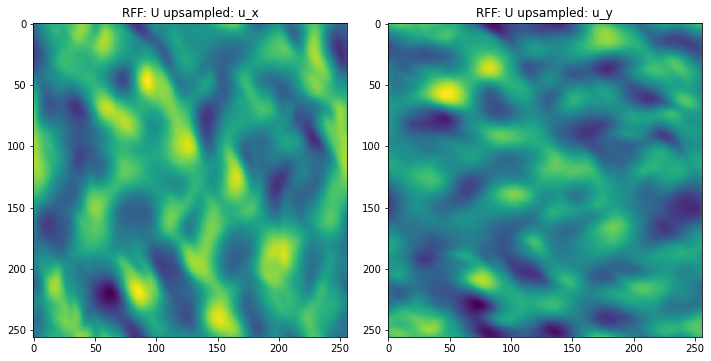

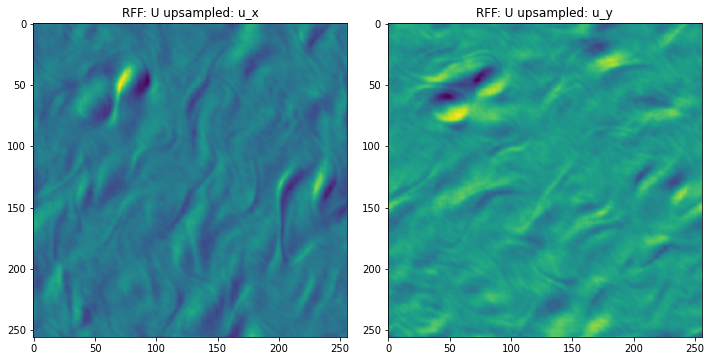

In [25]:
x = torch.from_numpy(Xhr).float().contiguous().to(device)

sfunrffnet.eval().to(device)
pred = sfunrffnet(x)
Udfphy = pred.cpu().detach().numpy().squeeze().reshape(H,H,2)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Udfphy[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Udfphy[:,:,1])
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Udfphy[:,:,0] - Uhr.reshape(H,H,2)[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Udfphy[:,:,1] - Uhr.reshape(H,H,2)[:,:,1])
plt.tight_layout()
plt.show()

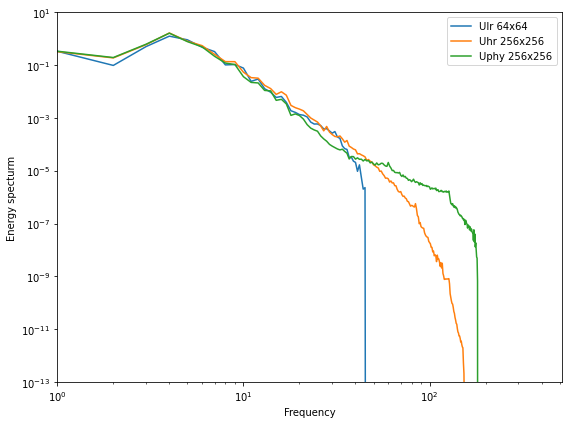

In [32]:
from turboflow.utils import phy_utils as phy

fig, axs = plt.subplots(1,1,figsize=(8,6))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Udfphy.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Udfphy.reshape(H,H,2)[:,:,0]), label='Uphy 256x256')
axs.set_ylim(10**(-13), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

(65536, 2)


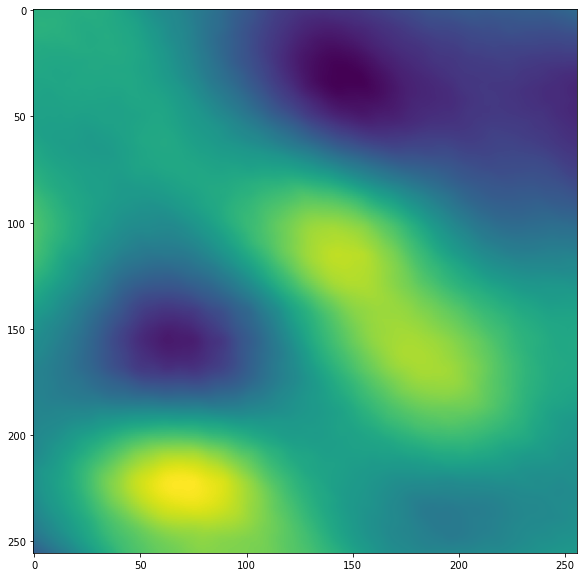

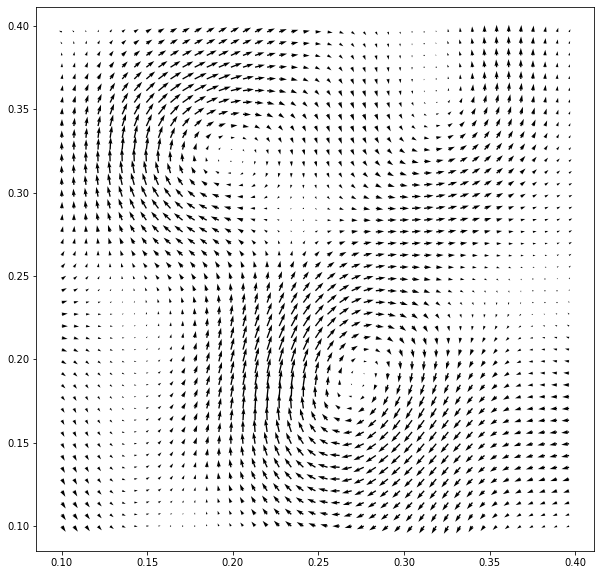

In [30]:
import numpy as np
# Let s zoom in it!
ngrid = 256
coords = np.linspace(0.1, 0.4, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

sfunrffnet.eval().to(device)
pred = sfunrffnet(x)
pred = pred.cpu().detach().numpy().squeeze().reshape(ngrid,ngrid,2)

plt.figure(figsize=(10,10))
plt.imshow(pred[:,:,0])
plt.show()

s = 6
plt.figure(figsize=(10,10))
plt.quiver(coords.reshape(ngrid,ngrid,2)[::s,::s,0],
           coords.reshape(ngrid,ngrid,2)[::s,::s,1],
           pred[::s,::s,0],pred[::s,::s,1])